<a href="https://colab.research.google.com/github/sejin-sim/Hands_On_ML/blob/master/%5B%ED%95%B8%EC%A6%88%EC%98%A8%5D_Chapter7_%EC%95%99%EC%83%81%EB%B8%94_%ED%95%99%EC%8A%B5%EA%B3%BC_%EB%9E%9C%EB%8D%A4_%ED%8F%AC%EB%A0%88%EC%8A%A4%ED%8A%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- 앙상블 : 일련의 예측기 (하나 이상)
- 랜덤 포레스트(random forest) : 결정 트리의 앙상블

## 1. 투표 기반 분류기
- 직접 투표(hard voting) 분류기 : 각 분류기의 예측을 모아서 가장 많이 선택된 클래스를 예측, 다수결 투표로 정해지는 분류기
 > 만약 훈련 결과가 모두 독립이라면 51%의 정확도를 가진 1000개의 분류기로 75% 정확도를 기대할 수 있다. 
- 간접 투표(soft voting) 분류기 : 개별 분류기의 예측을 평균 내어 확률이 가장 높은 클래스를 예측 → 성능이 더 좋다.


In [1]:
import numpy as np
import os

# %matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
mpl.rcParams['axes.unicode_minus'] = False
mpl.rcParams.update({"axes.grid" : True})

plt.rcParams["figure.figsize"] = (12,6)
plt.rc("font", size=18)  # 그림의 폰트 크기를 18로 고정
gray = {"facecolor": "gray"}
black = {"facecolor": "black"}
red = {"facecolor": "red"}
green = {"facecolor": "green"}
blue = {"facecolor": "blue"}

np.random.seed(42)

# %config InlineBackend.figure_format = 'retina'
 
!apt -qq -y install fonts-nanum
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 13 not upgraded.


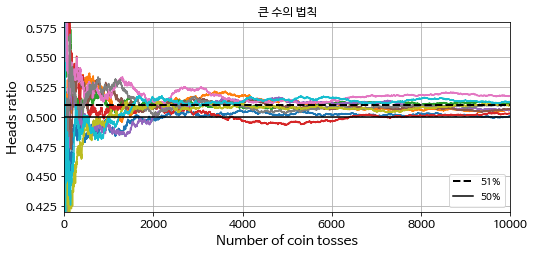

In [3]:
heads_proba = 0.51
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)

plt.figure(figsize=(8,3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
plt.title("큰 수의 법칙")
plt.show()

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')

voting_clf.fit(X_train, y_train)

from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


- voting='hard' 직접 투표

LogisticRegression 0.864   
RandomForestClassifier 0.896   
SVC 0.896   
VotingClassifier 0.912

In [7]:
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


- voting='soft' 간접 투표

LogisticRegression 0.864   
RandomForestClassifier 0.896   
SVC 0.896   
VotingClassifier 0.92

- 투표 기반 분류기가 다른 개별 분류기보다 성능이 높다.

## 2. 배깅과 페이스팅

1. 같은 훈련 세트의 서브셋을 무작위로 구성하여 분류기를 각기 다르게 학습
> 1. 배깅(bagging=boostrap aggregating) : 훈련 세트에서 중복을 허용하여 샘플링 (ex. 랜덤 포레스트)
> 2. 페이스팅(pasting : 중복을 허용하지 않고 샘플링

2. 모든 예측기가 훈련을 마치면 앙상블은 예측기의 예측을 모아서 새로운 샘플에 대한 예측을 만든다.
> 수집함수는 전형적으로 분류-통계적 최반 값, 회귀-평균

3. 앙상블은 비슷한 편향에서 더 작은 분산을 만들고, 병렬로 학습 시킬 수 있다. 

### 1) 사이킷런의 배깅과 페이스팅

In [13]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    max_samples=100, bootstrap=True, random_state=42)
    # 결정 트리 분류기 500개의 앙상블을 훈련. 100개의 샘플로 훈련
    # bootstrap=True=배깅, False = 페이스팅
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.904


In [9]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


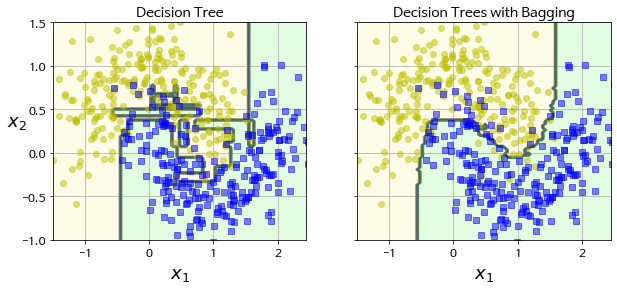

In [10]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.ylabel("")
plt.show()

- 앙상블 예측이 결정 트리 하나의 예측보다 일반화가 잘되었다.(비슷한 편향에서 더 작은 분산을 만든다.)
- 일반적으로 페이스팅보다 배깅이 더 나은 모델을 만든다.
> 배깅은 서브셋에 다양성을 증가시켜서 예측기들의 상관관계를 줄이므로 앙상블의 분산을 감소시킴

### 2) oob 평가

- 배깅을 사용하면 어떤 샘플은 여러번 샘플링 되고 어떤 것은 전혀 선택되지 않는다.

- oob(out-of-bag) 샘플 : 선택되지 않은 훈련 샘플의 나머지 대략 37%

In [14]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    bootstrap=True, oob_score=True, random_state=40)
    # oob_score=True 훈련이 끝난 후 자동으로 oob 평가를 수행
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.9013333333333333

In [15]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

- oob 평가 결과는 90%, 테스트 세트 결과는 91%로 비슷하다.

In [22]:
bag_clf.oob_decision_function_[0:3]

array([[0.31746032, 0.68253968],
       [0.34117647, 0.65882353],
       [1.        , 0.        ]])

- 첫 번째 훈련 샘플이 양성 클래스에 속할 확률을 68.25%로 추정 (음성은 31.75%)

<br/>

### 3) 랜덤 패치와 랜덤 서브스페이스

- BaggingClassifier 클래스는 특성 샘플링도 지원한다.

1. 랜덤 패치 방식 : 훈련과 샘플을 모두 샘플링하는 것

2.  랜덤 서브스페이스 방식 : 훈련 샘플을 모두 사용하고, 특성은 샘플링하는 것

3. 장점
 - 특성 샘플링은 더 다양한 예측기를 만들며, 편향을 늘리는 대신 분산을 낮춘다.
 - 이 기법은 (이미지와 같은) 고차원의 데이터 셋을 다룰 때 유용하다.

</br>

## 4. 랜덤 포레스트

1. 랜덤 포레스트는 일반적으로 배깅 방법(또는 페이스팅 방법)을 적용한 결정 트리의 앙상블이다.
>  max_samples를 훈련 세트의 크기로 지정한다.

2. 사이킷런의 RandomForestClassifier 또는 RandomForestRegressor 클래스를 사용하면 된다.

3. 랜덤 포레스트 알고리즘 : 트리의 노드를 분할 시 전체 특성 중에서 최적의 특성을 찾는 대신, 무작위로 선택한 특성 후보 중에서 최적의 특성을 찾는 방식이다. (무작위성을 더 주입)

4. 이 과정에서 트리를 더욱 다양하게 만들고, 편향을 늘리는 대신 분산을 낮추어 전체적으로 더 훌륭한 모델을 만들어낸다.



In [26]:
# RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

In [27]:
# BaggingClassifier 사용하여 RandomForestClassifier와 유사하게
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_leaf_nodes=16, random_state=42),
    n_estimators=500, max_samples=1.0, bootstrap=True, random_state=42)

bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [29]:
np.sum(y_pred == y_pred_rf) / len(y_pred)  # 거의 예측 동일.

0.952

### 1) 엑스트라 트리

1. 엑스트라 트리(또는 익스트림 랜덤 트리) : 트리를 더욱 무작위하게 만들기 위해 최적의 임계값을 찾는 대신 후보 특성을 사용해 무작위로 분할한 다음, 그 중 최상의 분할을 선택하는 방식
> 편향 ↑ 분산 ↓
2. 일반적인 랜덤 포레스트보다 엑스트라 트리가 훨씬 빠르다.

### 2) 특성 중요도

1. 랜덤 포레스트의 장점 중 하나는 특성의 상대적 중요도를 측정하기 쉽다는 것

2. 사이킷런은 어떤 특성을 사용한 노드가 평균적으로 불순도를 얼마나 감소시키는지 확인하여 특성의 중요도를 측정한다

3. 사이킷런은 훈련이 끝난 뒤 특성마다 자동으로 이 점수를 계산하고, 특성 중요도의 전체 합이 1이 되도록 결과값을 정규화한다.
> 해당 결과값은 feature_importances_ 변수에 저장

4. 랜덤 포레스트는 Feature Selection 작업을 수행할 때, 어떤 특성이 중요한지 빠르게 확인할 수 있다.

In [30]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])

for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


In [31]:
rnd_clf.feature_importances_

array([0.11249225, 0.02311929, 0.44103046, 0.423358  ])

- 각 특성의 중요도를 출력해 보면, 꽃잎의 길이(44%)와 꽃잎의 너비(42%)가 비교적 중요하다.

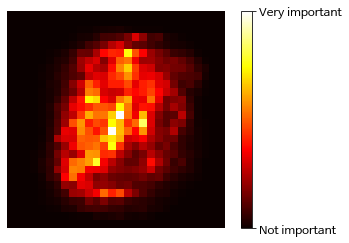

In [33]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.hot,
               interpolation="nearest")
    plt.axis("off")

plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

plt.show()

- MNIST 데이터셋에 랜덤 포레스트 분류기를 훈련시키고 각 픽셀의 중요도를 그래프로 나타내면 위와 같은 이미지를 얻게 된다.

- 랜덤 포레스트는 특히 특성을 선택할 때 어떤 특성이 중요한지 빠르게 확인 할 수 있어 매우 편리하다.

<br/>

## 5. 부스팅
- 부스팅(boosting) : 여러 개의 약한 학습기(weak learner)를 연결하여 강한 학습기를 만드는 앙상블 방법이다.
> 약한 학습기 여러 개를 순차적으로 학습-예측하면서 잘못 예측한 데이터에 가중치를 부여하고, 오류를 개선해 나가는 학습 방식

### 1) 에이다부스트(AdaBoost)

1. 에이다부스트(AdaBoost) : 이전 모델이 과소적합했던 훈련 샘플의 가중치를 업데이트하면서 순차적으로 학습하는 방식


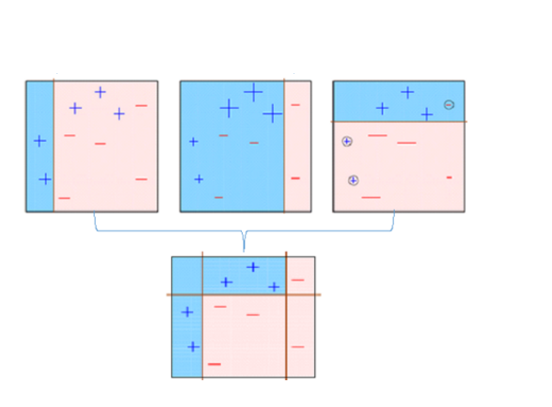

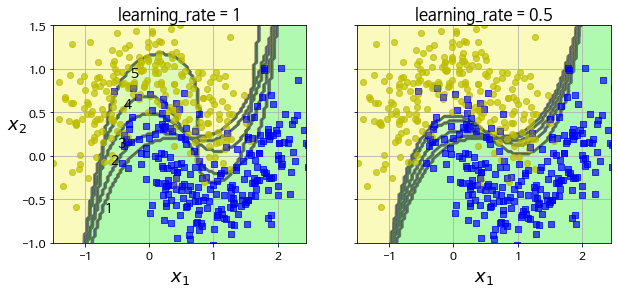

In [36]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

m = len(X_train)

fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
for subplot, learning_rate in ((0, 1), (1, 0.5)):
    sample_weights = np.ones(m)
    plt.sca(axes[subplot])
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.05, gamma="scale", random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights)
        y_pred = svm_clf.predict(X_train)
        sample_weights[y_pred != y_train] *= (1 + learning_rate)
        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
    if subplot == 0:
        plt.text(-0.7, -0.65, "1", fontsize=14)
        plt.text(-0.6, -0.10, "2", fontsize=14)
        plt.text(-0.5,  0.10, "3", fontsize=14)
        plt.text(-0.4,  0.55, "4", fontsize=14)
        plt.text(-0.3,  0.90, "5", fontsize=14)
    else:
        plt.ylabel("")

plt.show()

### 2) 그레이디언트 부스팅

- 그레디언트 부스팅(Gradient Boosting) : 에이다부스트(AdaBoost)처럼 매 반복마다 샘플의 가중치를 수정하지 않고, 이전 예측기가 만든 **잔여 오차(residual error)**에 새로운 예측기를 학습시킨다.




In [37]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

X_new = np.array([[0.8]])

y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

y_pred

array([0.75026781])

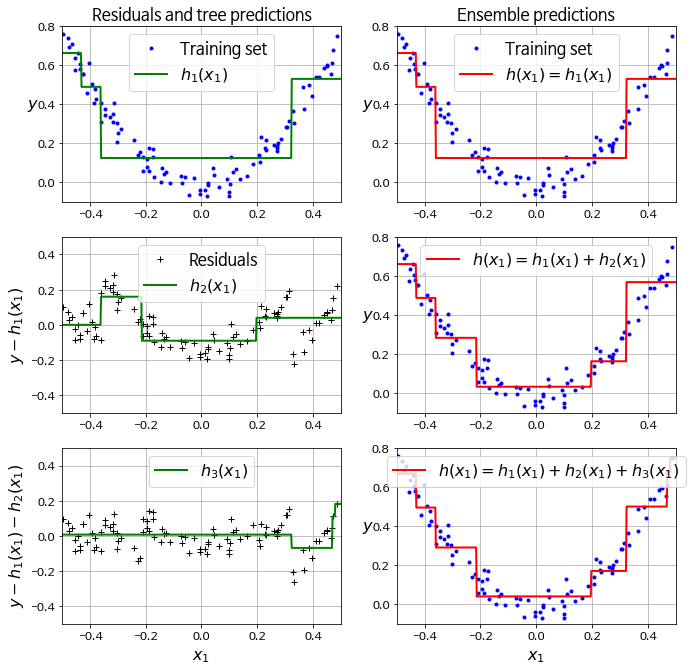

In [38]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.show()

- 트리가 앙상블에 추가될수록 앙상블의 예측이 점점 좋아지는 것을 확인할 수 있다.

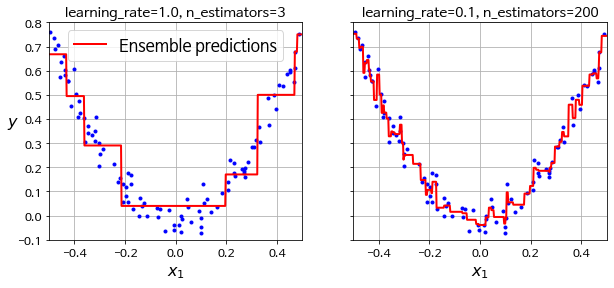

In [39]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)

plt.show()

- 학습률을 낮게 설정하면 일반적으로 예측의 성능이 좋아지고, 이는 축소(Shrinkage)라고 부르는 규제 방법이다.

- 왼쪽 그래프는 훈련 하기에 트리가 충분하지 않고, 오른쪽은 트리가 너무 많아 과대적합

- 최적의 트리 수를 찾기 위해 조기 종료 기법을 사용해 보자!


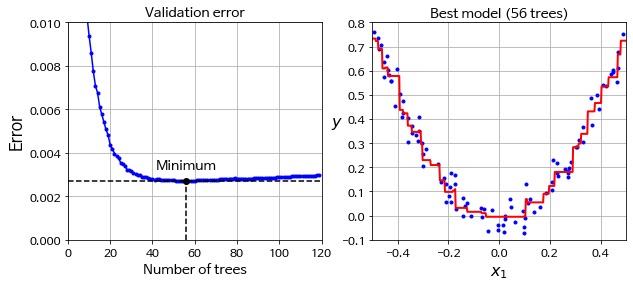

In [41]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

min_error = np.min(errors)

plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.ylabel("Error", fontsize=16)
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)
plt.show()

- 왼쪽 그래프는 검증 오차이고, 오른쪽 그래프는 최적 모델의 예측이다.

- 훈련을 중지하는 방법으로 조기 종료를 구현할 수 있다.

In [43]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)
# warm_start=True 사이킷런 fit()일 때 기존 트리를 유지하고, 훈련을 추가할 수 있도록 해준다.

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # early stopping(조기 종료)

print(gbrt.n_estimators)
print("Minimum validation MSE:", min_val_error)

61
Minimum validation MSE: 0.002712853325235463


- GradientBoostingRegressor은 각 트리가 훈련할 때 사용할 훈련 샘플의 비율을 지정할 수도 있다.
> subsample 매개변수를 조절

- 이와 같은 기법을 확률적 그레디언트 부스팅(Stochastic Gradient Boosting)이라고 한다.

### XGBOOST

1. XGBOOST(Extreme Gradient Boosting)  : 최적화된 그레이디언트 부스팅의 구현
2. 매우 빠른 속도와 확장성, 그리고 이식성을 갖추고 있다.
3. 자동 조기 종료와 같은 여러 좋은 기능들도 제공

In [49]:
from xgboost import XGBRegressor

xgb_reg = XGBRegressor(random_state=42, objective='reg:squarederror')
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_val)

val_error = mean_squared_error(y_val, y_pred)
print("Validation MSE:", val_error,"\n")     

xgb_reg.fit(X_train, y_train,
            eval_set=[(X_val, y_val)], early_stopping_rounds=2)
y_pred = xgb_reg.predict(X_val)
val_error = mean_squared_error(y_val, y_pred) 
print("Validation MSE:", val_error)           

Validation MSE: 0.0028512559726563943 

[0]	validation_0-rmse:0.286719
Will train until validation_0-rmse hasn't improved in 2 rounds.
[1]	validation_0-rmse:0.258221
[2]	validation_0-rmse:0.232634
[3]	validation_0-rmse:0.210526
[4]	validation_0-rmse:0.190232
[5]	validation_0-rmse:0.172196
[6]	validation_0-rmse:0.156394
[7]	validation_0-rmse:0.142241
[8]	validation_0-rmse:0.129789
[9]	validation_0-rmse:0.118752
[10]	validation_0-rmse:0.108388
[11]	validation_0-rmse:0.100155
[12]	validation_0-rmse:0.09208
[13]	validation_0-rmse:0.084791
[14]	validation_0-rmse:0.078699
[15]	validation_0-rmse:0.073248
[16]	validation_0-rmse:0.069391
[17]	validation_0-rmse:0.066277
[18]	validation_0-rmse:0.063458
[19]	validation_0-rmse:0.060326
[20]	validation_0-rmse:0.0578
[21]	validation_0-rmse:0.055643
[22]	validation_0-rmse:0.053943
[23]	validation_0-rmse:0.053138
[24]	validation_0-rmse:0.052415
[25]	validation_0-rmse:0.051821
[26]	validation_0-rmse:0.051226
[27]	validation_0-rmse:0.051135
[28]	validati

## 6. 스태킹(Stacking)

1. 스태킹(Stacking) : 여러 알고리즘을 서로 결합해 예측 결과를 도출한다는 점에서 배깅 및 부스팅과 유사하지만, 개별 알고리즘으로 예측한 데이터를 기반으로 다시 예측을 수행한다는 점이 다르다.

2. 과정
 - 개별 알고리즘의 예측 결과 데이터 세트를 최종적인 메타 데이터 세트로 만든다.
 - 별도의 머신러닝 알고리즘으로 최종 학습을 수행한다.
 - 테스트 데이터를 기반으로 다시 최종 예측(메타 모델을 사용)을 수행한다.

3. 필요한 두가지 모델
 - 개별적인 기반 모델 (스태킹을 적용할 때는 많은 개별 모델들이 필요함)
 - 개별 기반 모델의 예측 데이터를 학습 데이터로 만들어서 학습하는 최종 메타 모델  

4. 핵심 : 여러 개별 모델의 예측 데이터를 각각 스태킹 형태로 결합해, 최종 메타 모델의 학습용 피처 데이터 세트와 테스트용 피처 데이터 세트를 만드는 것